# Steady State Simulations

In [2]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

## Simulation: Pandemic

In [3]:
def SimulateOneRun(T):
    N = 1000 # total population
    I0 = 1 # initial number of infected
    R0 = 0 # initial number of recovered
    S0 = N - I0 - R0 # initial number of susceptible
    
    contact_rate = 0.2
    recovery_rate = 1/10
    resusceptibility_rate = 1/30
    
    I_list = [I0]
    R_list = [R0]
    S_list = [S0]
    I = I0
    R = R0
    S = S0
    for t in range(T-1):
        I_prev = I
        R_prev = R
        S_prev = S
        # update new numbers of infected, recovered, susceptible
        I = I_prev + contact_rate * S_prev * I_prev / N - recovery_rate * I_prev
        R = R_prev + recovery_rate * I_prev - resusceptibility_rate * R_prev
        S = S_prev - contact_rate * S_prev * I_prev / N + resusceptibility_rate * R_prev
        # generate some noise
        noise = np.random.normal(0,1)
        # make sure noise doesn't result in negative numbers
        if noise >= 0:
            noise = min(S,noise)
            noise = min(N-I,noise)
        else:
            noise = - min(N-S,-noise)
            noise = - min(I,-noise)
        I = I + noise
        S = S - noise
        I_list.append(I)
        R_list.append(R)
        S_list.append(S)
    return I_list, R_list, S_list

In [4]:
T=500
I_list, R_list, S_list = SimulateOneRun(T)
results = pd.DataFrame({"Time":[t for t in range(T)],
                        "Infected":I_list,
                        "Recovered":R_list,
                        "Susceptible":S_list})

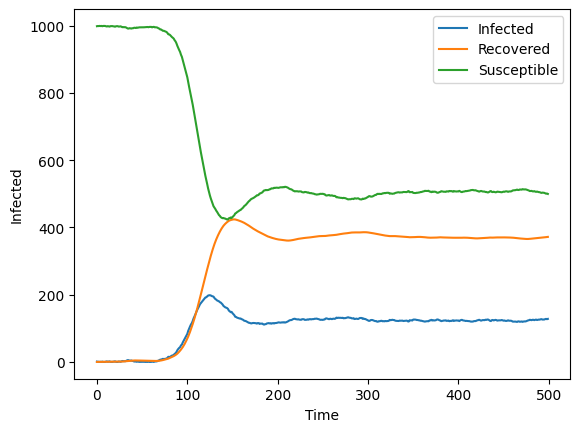

In [5]:
sns.lineplot(data=results,x='Time',y='Infected',label='Infected')
sns.lineplot(data=results,x='Time',y='Recovered',label='Recovered')
sns.lineplot(data=results,x='Time',y='Susceptible',label='Susceptible')
plt.show()

## Eliminate initialisation bias: Welch's method

In [7]:
# Remove initialisation bias
# Step 1: Run k independent simulations
n_rep = 50
runs = []
timestamps = []
susceptible_list = []
for n in range(1,n_rep+1):
    run = [n] * T
    runs.extend(run)
    timestamp = [t for t in range(1,T+1)]
    timestamps.extend(timestamp)
    _, _, susceptible = SimulateOneRun(T)
    susceptible_list.extend(susceptible)
results = pd.DataFrame({'Run': runs, 'Time': timestamps, 'Value': susceptible_list})

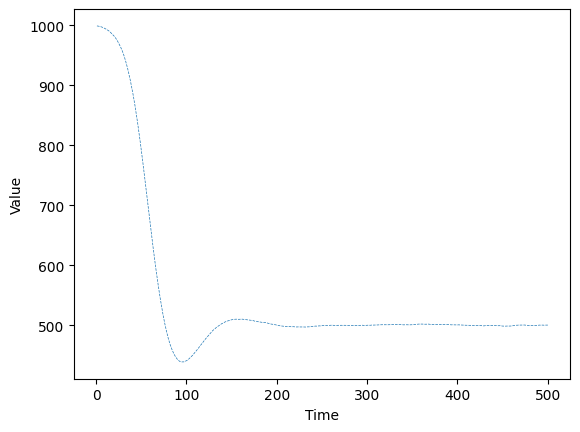

In [8]:
# Step 2: Average matching observations
# Average the value at each time period, over all k runs.
ave_results = results.groupby('Time',as_index=False)['Value'].mean()
sns.lineplot(x='Time',y='Value',data=ave_results,linestyle='--',linewidth=0.5)
plt.show()

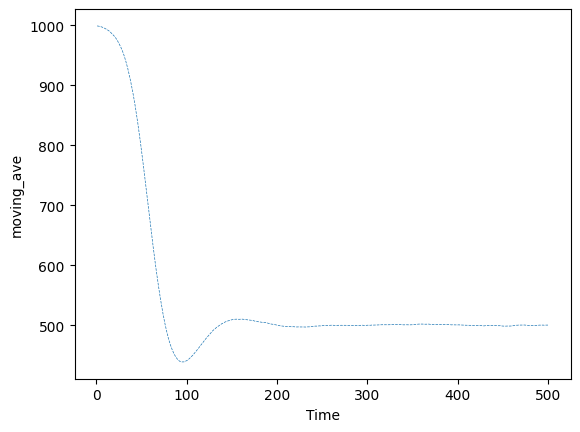

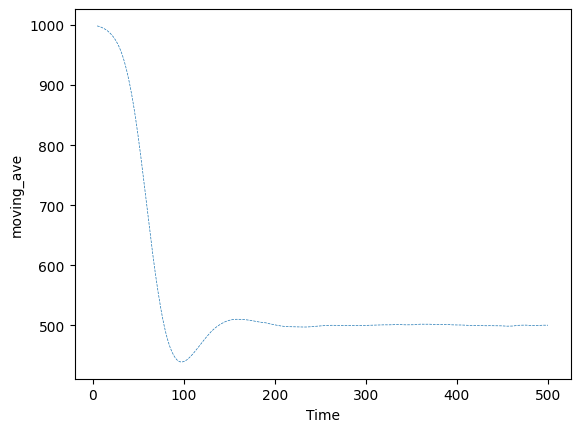

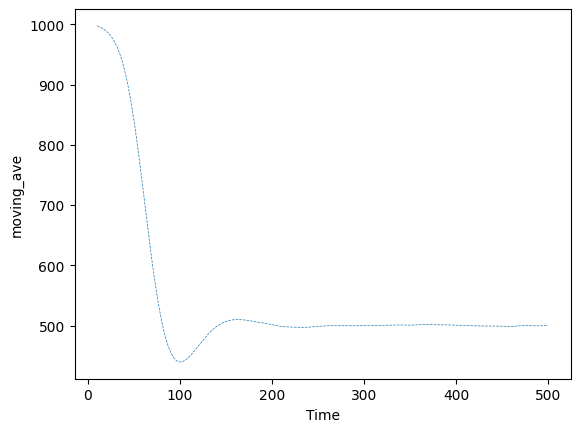

In [11]:
# Step 4: compute moving averages for different window lengths
for mavg in [1,5,10]:
    ave_results['moving_ave'] = ave_results['Value'].rolling(mavg).mean()
    sns.lineplot(x='Time',y='moving_ave',data=ave_results,linestyle='--',linewidth=0.5)
    plt.show()

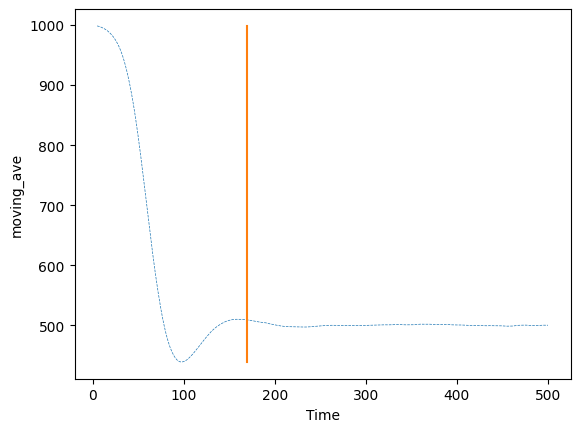

In [14]:
# Step 5: Determine burn-in period by inspection
mavg = 5
ave_results['moving_ave'] = ave_results['Value'].rolling(mavg).mean()
sns.lineplot(x='Time',y='moving_ave',data=ave_results,linestyle='--',linewidth=0.5)
burn_in = 170
plt.plot([burn_in, burn_in], [min(ave_results['moving_ave'][mavg-1:]), max(ave_results['moving_ave'][mavg-1:])])
plt.show()

## Estimating confidence interval: Replication/deletion

In [20]:
# We want to run the procedure for terminating simulations\
# using replication/deletion
def SteadyStateSusceptible(T,burn_in,tol):
    # initialization
    n_initial = 20
    mean_S = 0
    var_S = 0
    i = 1
    stop = False
    # stop if number of iterations is > n_initial and t_score * standard error < tolerance
    desired_accuracy = 0.95
    while stop == False:
        _,_,sample_S_list = SimulateOneRun(T)
        sample_S = np.mean(sample_S_list[burn_in:]) # fill in here: drop burn-in period and take mean of remaining observations
        mean_prev = mean_S # store previous mean
        var_prev = var_S # store previous variance
        mean_S = mean_prev + (sample_S-mean_prev)/i # update mean
        if i > 1:
            # update variance
            var_S = (1 - 1/(i-1)) * var_prev + i * (mean_S - mean_prev)**2
        # check for termination
        se = math.sqrt(var_S/i)
        # compute required t_score
        t_score = stats.t.ppf(1 - (1-desired_accuracy)/2, df=i-1)
        if (i > n_initial) and (t_score*se < tol):
            stop = True
        else:
            i = i + 1
    print("Estimate for expected steady state susceptible: {}".format(mean_S))
    print("Standard error of estimate: {}".format(se))
    print("Number of simulation runs required: {}".format(i))
    return mean_S, se, i

In [23]:
T = 1000 # Note: the length of each run D should be at least 5-10 times the identified burn-in period
# burn-in identified from previous part
tol = 0.5
SteadyStateSusceptible(T,burn_in,tol)

Estimate for expected steady state susceptible: 500.05023976802084
Standard error of estimate: 0.2388657917250254
Number of simulation runs required: 29


(np.float64(500.05023976802084), 0.2388657917250254, 29)

## Estimating confidence interval: Batch-means

In [24]:
def SimulateOneRunContinue(last_I,last_R,last_S,T):
    # continue simulation for T more periods,
    # based on most recent state (I,R,S)
    N = 1000 # total population
    I0 = last_I # initial number of infected
    R0 = last_R # initial number of recovered
    S0 = last_S # initial number of susceptible
    
    contact_rate = 0.2
    recovery_rate = 1/10
    resusceptibility_rate = 1/30
    
    I_list = []
    R_list = []
    S_list = []
    I = I0
    R = R0
    S = S0
    for t in range(T):
        I_prev = I
        R_prev = R
        S_prev = S
        # update new numbers of infected, recovered, susceptible
        I = I_prev + contact_rate * S_prev * I_prev / N - recovery_rate * I_prev
        R = R_prev + recovery_rate * I_prev - resusceptibility_rate * R_prev
        S = S_prev - contact_rate * S_prev * I_prev / N + resusceptibility_rate * R_prev
        # generate some noise
        noise = np.random.normal(0,1)
        # make sure noise doesn't result in negative numbers
        if noise >= 0:
            noise = min(S,noise)
            noise = min(N-I,noise)
        else:
            noise = - min(N-S,-noise)
            noise = - min(I,-noise)
        I = I + noise
        S = S - noise
        I_list.append(I)
        R_list.append(R)
        S_list.append(S)
    return I_list, R_list, S_list

In [30]:
# We want to run the procedure for terminating simulations
# using batch-means
def SteadyStateSusceptibleBatch(batch_size,burn_in,tol):
    # initialization
    n_batches_initial = 20
    mean_S = 0
    var_S = 0
    i = n_batches_initial
    stop = False
    # stop if number of batches is > n_batches_initial and t_score * standard error < tolerance
    desired_accuracy = 0.95
    initial_T = burn_in + n_batches_initial *  batch_size # fill in here
    # if we want n_batches_initial batches with size batch_size after dropping the burn-in period,
    # how long should we run our simulation for?
    while stop == False:
        if i == n_batches_initial:
            # initially, run a long simulation with initial number of batches
            sample_I_list,sample_R_list,sample_S_list = SimulateOneRun(initial_T)
            last_I = sample_I_list[-1]
            last_R = sample_R_list[-1]
            last_S = sample_S_list[-1]
            initial_batch_means = []
            for j in range(n_batches_initial):
                # drop burn-in period and partition into batches
                sample_S_batch = sample_S_list[burn_in+j*batch_size:burn_in+(j+1)*batch_size]
                # fill in here: which observations from sample_S_list should we select for batch j?
                # replace ??? with the appropriate values
                # recall that j ranges from 0 to n_batches_initial-1
                # and that sample_S_list[x:y] returns [sample_S_list[x],sample_S_list[x+2],...,sample_S_list[y-1]]
                # ie the (x+1)-th to the (y)-th elements inclusive
                sample_S = np.mean(sample_S_batch)
                initial_batch_means.append(sample_S)
            # compute mean and variance of the initial batch means
            mean_S = np.mean(initial_batch_means)
            var_S = np.var(initial_batch_means,ddof=1) # note: ddof=1 is to compute sample variance (1/(n_samples-1) instead of 1/n_samples)
            # check for termination
            se = math.sqrt(var_S/i)
            # compute required t_score
            t_score = stats.t.ppf(1 - (1-desired_accuracy)/2, df=i-1)
            if (i > n_batches_initial) and (t_score*se < tol):
                stop = True
            else:
                i = i + 1
        else:
            # then, continue that long simulation one batch at a time
            sample_I_list,sample_R_list,sample_S_list = SimulateOneRunContinue(last_I,last_R,last_S,batch_size)
            last_I = sample_I_list[-1]
            last_R = sample_R_list[-1]
            last_S = sample_S_list[-1]
            sample_S = np.mean(sample_S_list)
            mean_prev = mean_S # store previous mean
            var_prev = var_S # store previous variance
            mean_S = mean_prev + (sample_S-mean_prev)/i # update mean
            if i > 1:
                # update variance
                var_S = (1 - 1/(i-1)) * var_prev + i * (mean_S - mean_prev)**2
            # check for termination
            se = math.sqrt(var_S/i)
            # compute required t_score
            t_score = stats.t.ppf(1 - (1-desired_accuracy)/2, df=i-1)
            if (i > n_batches_initial) and (t_score*se < tol):
                stop = True
            else:
                i = i + 1
    print("Estimate for expected steady state susceptible: {}".format(mean_S))
    print("Standard error of estimate: {}".format(se))
    print("Number of simulation batches required: {}".format(i))
    return mean_S, se, i

In [31]:
batch_size = 890
SteadyStateSusceptibleBatch(batch_size,burn_in,tol)

Estimate for expected steady state susceptible: 500.3528458699254
Standard error of estimate: 0.23970149887310158
Number of simulation batches required: 23


(np.float64(500.3528458699254), 0.23970149887310158, 23)